In [ ]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from scipy.linalg import pinv
from PIL import Image
from tensorflow.keras.models import Model
import joblib
import numpy as np
import os
from numpy.linalg import pinv
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.spatial import distance
import os
import shutil
import random
import torch
import torch.nn as nn
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader



print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = "/content/drive/My Drive/CXR_train_images"
sampled_data_dir = "/content/drive/My Drive/CXR_sampled_dataset"

# Create the sampled dataset directory if it doesn't exist
if not os.path.exists(sampled_data_dir):
    os.makedirs(sampled_data_dir)

# Sample images from each class
for class_dir in os.listdir(data_dir):
    class_images = os.listdir(os.path.join(data_dir, class_dir))
    num_to_sample = min(200, len(class_images))
    sampled_class_images = random.sample(class_images, num_to_sample)
    new_class_dir = os.path.join(sampled_data_dir, class_dir)
    if not os.path.exists(new_class_dir):
        os.makedirs(new_class_dir)
    for image in sampled_class_images:
        shutil.copy2(os.path.join(data_dir, class_dir, image), os.path.join(new_class_dir, image))

# Image data generators for training and validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.10)

train_generator = datagen.flow_from_directory(
    sampled_data_dir,
    subset="training",
    class_mode="binary",
    target_size=(224, 224),
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    sampled_data_dir,
    subset="validation",
    class_mode="binary",
    target_size=(224, 224),
    shuffle=True
)

Found 6146 images belonging to 2 classes.
Found 682 images belonging to 2 classes.


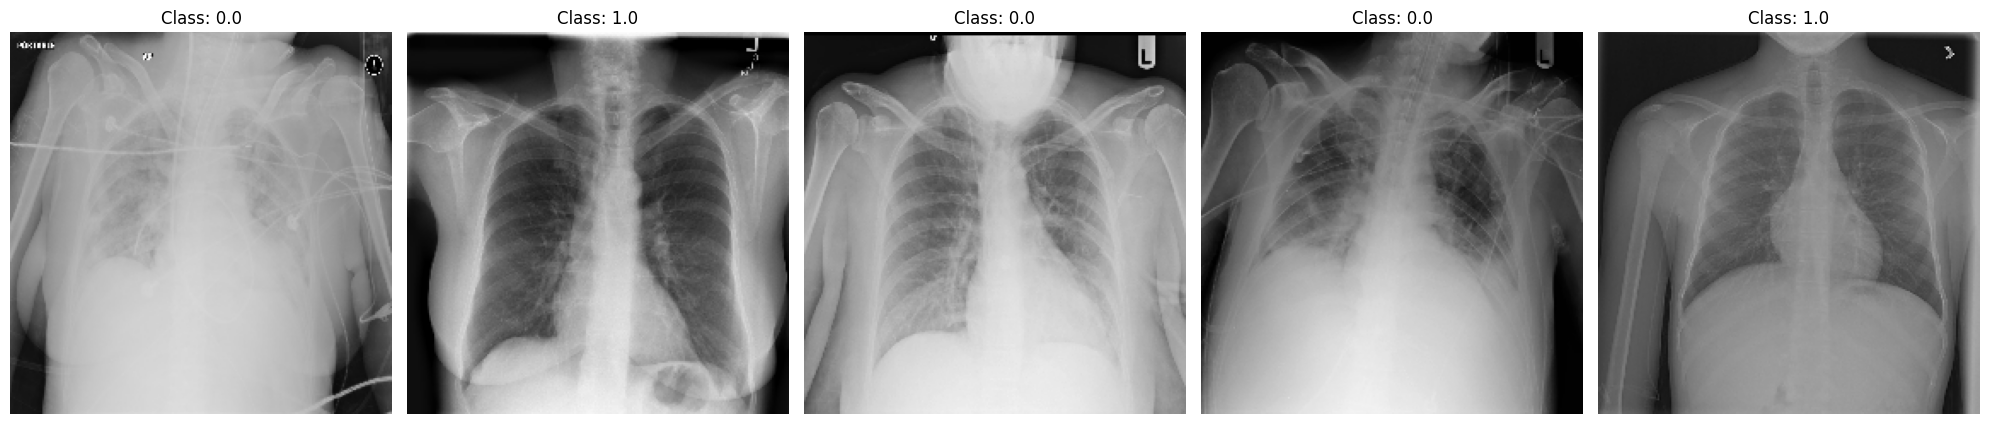

In [ ]:
# Function to plot images
def plot_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img)
        ax.set_title(f"Class: {label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display 5 images from the training set
images, labels = next(train_generator)
plot_images(images[:5], labels[:5])


# Function to remove corrupted images
def check_and_delete_corrupted_images(directory):
    for subdir, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Deleting corrupted image: {file_path}")
                os.remove(file_path)

check_and_delete_corrupted_images(sampled_data_dir)


In [ ]:
import torch
import torch.nn as nn
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

class Encoder(nn.Module):
    def __init__(self, c_hid=16, latent_dim=100):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, c_hid, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            # Add more layers if needed
        )

        # Calculate the size of the flattened output after the last conv layer
        self.flattened_size = self._get_conv_output((3, 224, 224))

        # Linear layer
        self.linear = nn.Linear(self.flattened_size, latent_dim)

    def _get_conv_output(self, shape):
        # Pass a dummy input through the convolutional layers to calculate output size
        input = torch.rand(1, *shape)
        output = self.conv_layers(input)
        return int(np.prod(output.size()))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view
        x = self.linear(x)
        return x


class Decoder(nn.Module):
    def __init__(self, c_hid=16, latent_dim=100):
        super(Decoder, self).__init__()
        # Adjust the output size of the linear layer
        self.linear = nn.Sequential(nn.Linear(latent_dim, 7 * 7 * c_hid), nn.ReLU())

        self.network = nn.Sequential(
            # Upsampling to 14x14
            nn.ConvTranspose2d(c_hid, c_hid, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Upsampling to 28x28
            nn.ConvTranspose2d(c_hid, c_hid // 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Upsampling to 56x56
            nn.ConvTranspose2d(c_hid // 2, c_hid // 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Upsampling to 112x112
            nn.ConvTranspose2d(c_hid // 4, c_hid // 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Upsampling to 224x224 (special adjustment needed)
            nn.ConvTranspose2d(c_hid // 8, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 7, 7)  # Reshape for the starting shape
        x = self.network(x)
        return x



class ConvAutoEncoderCore(nn.Module):
    def __init__(self, c_hid=16, latent_dim=100):
        super(ConvAutoEncoderCore, self).__init__()
        self.encoder = Encoder(c_hid, latent_dim)
        self.decoder = Decoder(c_hid, latent_dim)

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def features(self, x: torch.Tensor):
        return self.encoder(x)


In [ ]:
from tqdm import tqdm
import math
import torch
import torch.optim as optim


num_epochs = 10
train_losses, val_losses = [], []


# Instantiate the model
autoencoder = ConvAutoEncoderCore()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


# Calculate the total number of iterations per epoch for train and validation
total_train_iterations = math.ceil(train_generator.samples / train_generator.batch_size)
total_val_iterations = math.ceil(validation_generator.samples / validation_generator.batch_size)

for epoch in range(num_epochs):
    autoencoder.train()
    total_train_loss = 0
    train_bar = tqdm(total=total_train_iterations)
    train_batches_processed = 0

    for images, _ in train_generator:
        if train_batches_processed >= total_train_iterations:
            break

        # Convert images to tensor and normalize
        images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
        images = images * 2.0 - 1.0

        # Forward pass and compute loss
        outputs = autoencoder(images)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_bar.set_description(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss.item():.4f}")
        train_bar.update(1)
        train_batches_processed += 1

    train_bar.close()
    avg_train_loss = total_train_loss / train_batches_processed
    train_losses.append(avg_train_loss)

    # Validation phase
    autoencoder.eval()
    total_val_loss = 0
    val_bar = tqdm(total=total_val_iterations)
    val_batches_processed = 0

    with torch.no_grad():
        for images, _ in validation_generator:
            if val_batches_processed >= total_val_iterations:
                break

            images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
            images = images * 2.0 - 1.0
            outputs = autoencoder(images)
            loss = criterion(outputs, images)

            total_val_loss += loss.item()
            val_bar.set_description(f"Epoch [{epoch+1}/{num_epochs}] - Val Loss: {loss.item():.4f}")
            val_bar.update(1)
            val_batches_processed += 1

    val_bar.close()
    avg_val_loss = total_val_loss / val_batches_processed
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


Epoch [1/10] - Val Loss: 0.2787: 100%|██████████| 22/22 [00:16<00:00,  1.30it/s]


Epoch [1/10], Train Loss: 0.2606, Val Loss: 0.2636


Epoch [2/10] - Val Loss: 0.2686: 100%|██████████| 22/22 [00:17<00:00,  1.26it/s]


Epoch [2/10], Train Loss: 0.2591, Val Loss: 0.2631


Epoch [3/10] - Val Loss: 0.2874: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


Epoch [3/10], Train Loss: 0.2591, Val Loss: 0.2639


Epoch [4/10] - Val Loss: 0.2625: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


Epoch [4/10], Train Loss: 0.2591, Val Loss: 0.2642


Epoch [5/10] - Val Loss: 0.2593: 100%|██████████| 22/22 [00:17<00:00,  1.25it/s]


Epoch [5/10], Train Loss: 0.2588, Val Loss: 0.2642


Epoch [6/10] - Val Loss: 0.2540: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s]


Epoch [6/10], Train Loss: 0.2594, Val Loss: 0.2652


Epoch [7/10] - Val Loss: 0.2485: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


Epoch [7/10], Train Loss: 0.2591, Val Loss: 0.2583


Epoch [8/10] - Val Loss: 0.3085: 100%|██████████| 22/22 [00:17<00:00,  1.26it/s]


Epoch [8/10], Train Loss: 0.2590, Val Loss: 0.2673


Epoch [9/10] - Val Loss: 0.2580: 100%|██████████| 22/22 [00:17<00:00,  1.26it/s]


Epoch [9/10], Train Loss: 0.2596, Val Loss: 0.2611


Epoch [10/10] - Val Loss: 0.2376: 100%|██████████| 22/22 [00:17<00:00,  1.26it/s]

Epoch [10/10], Train Loss: 0.2587, Val Loss: 0.2623


In [ ]:
# Define the device to use (CPU or CUDA if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)  # Move the autoencoder to the defined device

def extract_features(generator, model):
    model.eval()
    features = []
    progress_bar = tqdm(generator, total=len(generator), desc="Extracting Features")
    progress_bar = tqdm(generator, total=len(generator), desc="Extracting Features")

    batches_processed = 0
    with torch.no_grad():
        for images, _ in progress_bar:
            if batches_processed >= len(generator):
                break  # Break the loop after processing all batches

            images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
            images = images * 2.0 - 1.0
            images = images.to(device)
            batch_features = model.encoder(images).cpu().numpy()
            features.append(batch_features)

            batches_processed += 1  # Increment the counter

    return np.concatenate(features)

# Extract features
train_features = extract_features(train_generator, autoencoder)
print("Finished extracting features from training data.")


Extracting Features:   0%|          | 0/193 [00:00<?, ?it/s]

Extracting Features: 100%|██████████| 193/193 [02:01<00:00,  1.59it/s]

Finished extracting features from training data.


In [ ]:
np.save('/content/drive/My Drive/train_unsupervised_features_CXR.npy', train_features)
# Print statistics
def print_stats(features, name):
    print(f"{name} Features - Mean: {np.mean(features):.4f}, Std: {np.std(features):.4f}")

print_stats(train_features, "Training")
print(len(train_features))
print(train_features.shape)

Training Features - Mean: 0.0014, Std: 0.0114
6146
(6146, 100)


In [ ]:
# rxtract features from in-dist and out-dist folders
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
import torch
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import DataLoader

import numpy as np
import torch
from tqdm import tqdm
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)

def extract_features_from_image(image_path, model, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size, color_mode='rgb')  # Ensure 3 channels for RGB
    img_array = img_to_array(img)
    img_tensor = torch.tensor(img_array, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Add batch dimension
    img_tensor = img_tensor * 2.0 - 1.0  # Normalize
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        features = model.encoder(img_tensor).cpu().numpy()
    return features.flatten()

def extract_features_from_folder(folder_path, model):
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return np.array([]), []
    image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path)]
    features = []
    filenames = []
    for img_path in tqdm(image_paths, desc=f"Extracting from {folder_path}"):
        try:
            img_features = extract_features_from_image(img_path, model)
            features.append(img_features)
            filenames.append(os.path.basename(img_path))
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return np.array(features), filenames



# Paths to the testing image folders
out_dist_folder = '/content/drive/MyDrive/out-dist-cxr'
in_dist_folder = '/content/drive/MyDrive/in_dist_pool'



In [ ]:

# Extract features using the autoencoder
in_dist_features, in_dist_filenames = extract_features_from_folder(in_dist_folder, autoencoder)
out_dist_features, out_dist_filenames = extract_features_from_folder(out_dist_folder, autoencoder)

np.save('/content/drive/My Drive/InDist_unsupervised_features_CXR.npy', in_dist_features)
np.save('/content/drive/My Drive/OutDist_unsupervised_features_CXR.npy', out_dist_features)

# Print statistics
def print_stats(features, name):
    print(f"{name} Features - Mean: {np.mean(features):.4f}, Std: {np.std(features):.4f}")
print("\n")
print_stats(train_features, "Training")
print_stats(in_dist_features, "In-dist")
print_stats(out_dist_features, "Out-dist")
print(len(in_dist_features))
print(in_dist_features.shape)
print(len(out_dist_features))
print(out_dist_features.shape)

Extracting from /content/drive/MyDrive/in_dist_pool: 100%|██████████| 1000/1000 [00:27<00:00, 36.25it/s]
Extracting from /content/drive/MyDrive/out-dist-cxr: 100%|██████████| 896/896 [00:19<00:00, 45.95it/s] 




Training Features - Mean: 0.0014, Std: 0.0114
In-dist Features - Mean: 0.2092, Std: 1.0869
Out-dist Features - Mean: 0.1438, Std: 0.8488
1000
(1000, 100)
896
(896, 100)


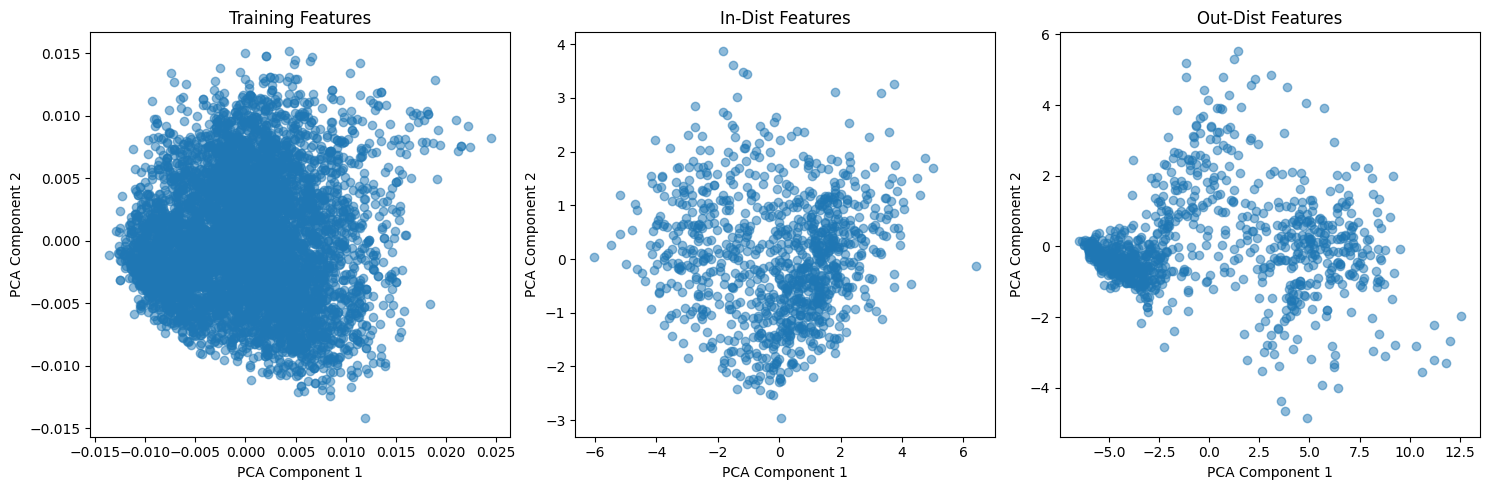

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to perform PCA and plot
def plot_pca(features, title, ax):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)
    ax.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each dataset
plot_pca(train_features, 'Training Features', axes[0])
plot_pca(in_dist_features, 'In-Dist Features', axes[1])
plot_pca(out_dist_features, 'Out-Dist Features', axes[2])

plt.tight_layout()
plt.show()


In [ ]:
# Load features from files
train_features = np.load('/content/drive/My Drive/train_unsupervised_features.npy')
in_dist_features = np.load('/content/drive/My Drive/in_dist_unsupervised_features.npy')
out_dist_features = np.load('/content/drive/My Drive/out_dist_unsupervised_features.npy')


In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import distance

# Function to compute cosine similarity
def compute_cosine_similarity(tr_features, tt_features):
    centroid = np.mean(tr_features, axis=0)
    similarities = [1 - distance.cosine(feature, centroid) for feature in tt_features]
    return similarities

# Computing the centroid and similarities for the training features
cosine_train_similarities = compute_cosine_similarity(train_features, train_features)

# Compute cosine similarities for in-distribution and out-of-distribution sets
cosine_in_dist_similarities = compute_cosine_similarity(train_features, in_dist_features)
cosine_out_dist_similarities = compute_cosine_similarity(train_features, out_dist_features)

# Save the similarities and image names to CSV files
in_dist_df = pd.DataFrame({'Image Name': in_dist_filenames, 'Cosine Similarity': cosine_in_dist_similarities})
out_dist_df = pd.DataFrame({'Image Name': out_dist_filenames, 'Cosine Similarity': cosine_out_dist_similarities})


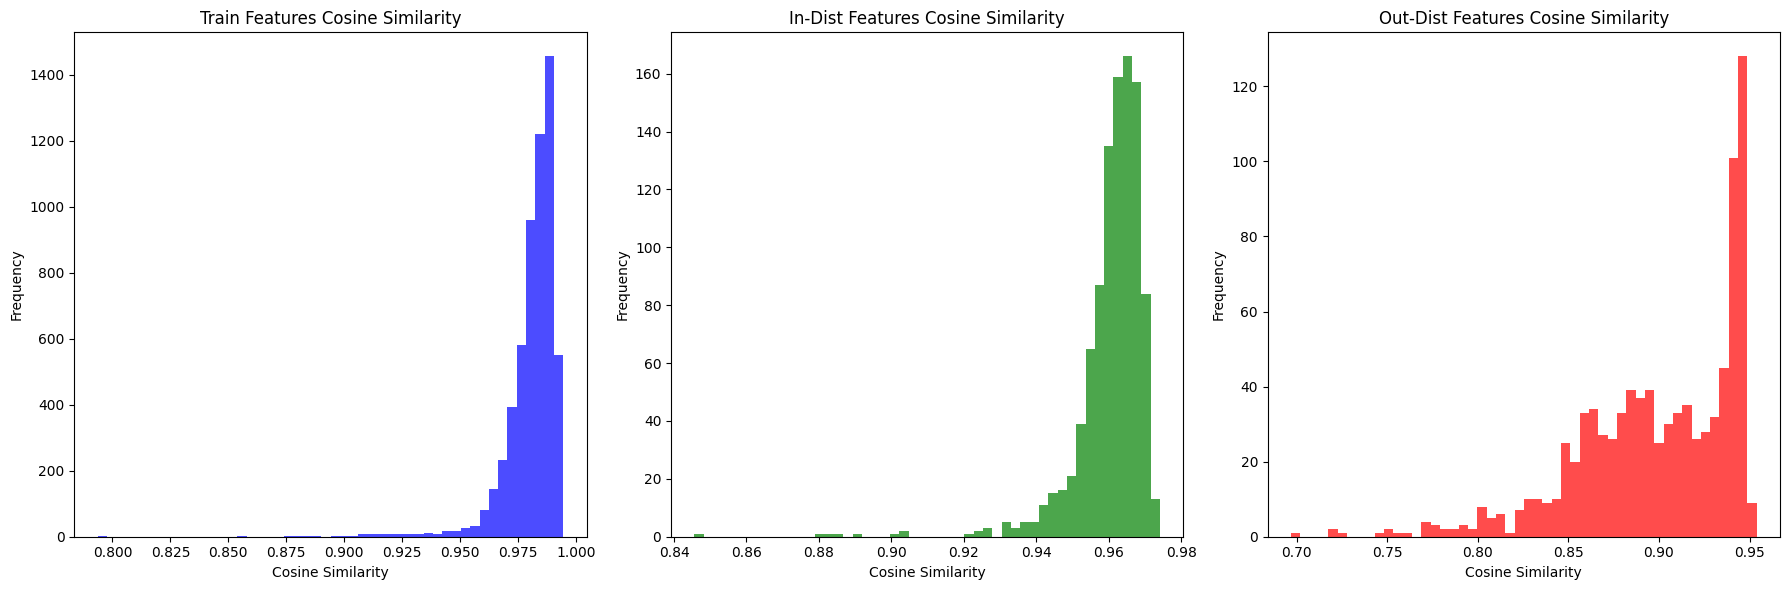

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create histograms
plt.figure(figsize=(18, 6))

# Training Features Histogram
plt.subplot(1, 3, 1)
plt.hist(cosine_train_similarities, bins=50, color='blue', alpha=0.7)
plt.title('Train Features Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# In-Dist Features Histogram
plt.subplot(1, 3, 2)
plt.hist(cosine_in_dist_similarities, bins=50, color='green', alpha=0.7)
plt.title('In-Dist Features Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# Out-Dist Features Histogram
plt.subplot(1, 3, 3)
plt.hist(cosine_out_dist_similarities, bins=50, color='red', alpha=0.7)
plt.title('Out-Dist Features Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# Compute mean and standard deviation for cosine similarities
mean_cosine_train = np.mean(cosine_train_similarities)
std_cosine_train = np.std(cosine_train_similarities)

mean_cosine_in_dist = np.mean(cosine_in_dist_similarities)
std_cosine_in_dist = np.std(cosine_in_dist_similarities)

mean_cosine_out_dist = np.mean(cosine_out_dist_similarities)
std_cosine_out_dist = np.std(cosine_out_dist_similarities)

# Print the statistics
print("Training Cosine Similarities - Mean:", mean_cosine_train, "Std:", std_cosine_train)
print("In-distribution Cosine Similarities - Mean:", mean_cosine_in_dist, "Std:", std_cosine_in_dist)
print("Out-of-distribution Cosine Similarities - Mean:", mean_cosine_out_dist, "Std:", std_cosine_out_dist)


Training Cosine Similarities - Mean: 0.9808872243932492 Std: 0.011751240732408632
In-distribution Cosine Similarities - Mean: 0.9605512012839317 Std: 0.010291083644327379
Out-of-distribution Cosine Similarities - Mean: 0.8987949028212044 Std: 0.04375138286533751


In [ ]:
# Assuming cosine_train_similarities is a list of similarity values
cosine_mean_train = np.mean(cosine_train_similarities)
cosine_std_train = np.std(cosine_train_similarities)

# Computing the 3-sigma upper and lower control limits
cosine_3UCL_train_upper = cosine_mean_train + 3 * cosine_std_train
cosine_3LCL_train_lower = cosine_mean_train - 3 * cosine_std_train


# Print the calculated statistics
print("Mean Cosine Similarity:", cosine_mean_train)
print("Standard Deviation of Cosine Similarity:", cosine_std_train)
print("3-Sigma Upper Control Limit:", cosine_3UCL_train_upper)
print("3-Sigma Lower Control Limit:", cosine_3LCL_train_lower)


Mean Cosine Similarity: 0.9808872243932492
Standard Deviation of Cosine Similarity: 0.011751240732408632
3-Sigma Upper Control Limit: 1.0161409465904752
3-Sigma Lower Control Limit: 0.9456335021960233


In [ ]:
# Assuming cosine_train_similarities is a list of similarity values
cosine_mean_in = np.mean(cosine_in_dist_similarities)
cosine_std_in = np.std(cosine_in_dist_similarities)

cosine_mean_out = np.mean(cosine_out_dist_similarities)
cosine_std_out = np.std(cosine_out_dist_similarities)

# Print the calculated statistics
print("Mean Cosine Similarity (in-dist):", cosine_mean_in)
print("Standard Deviation of Cosine Similarity (in-dist):", cosine_std_in)

print("Mean Cosine Similarity (out-dist):", cosine_mean_out)
print("Standard Deviation of Cosine Similarity (out-dist):", cosine_std_out)



Mean Cosine Similarity (in-dist): 0.9605512012839317
Standard Deviation of Cosine Similarity (in-dist): 0.010291083644327379
Mean Cosine Similarity (out-dist): 0.8987949028212044
Standard Deviation of Cosine Similarity (out-dist): 0.04375138286533751


In [ ]:
# Randomly pick 50 points from in-distribution and out-of-distribution cosine similarities
in_dist_samples = np.random.choice(cosine_in_dist_similarities, 50, replace=False)
out_dist_samples = np.random.choice(cosine_out_dist_similarities, 50, replace=False)

# Combine and shuffle these 100 points
combined_samples = np.concatenate((in_dist_samples, out_dist_samples))
# Also, create a label array to track InD (0) and OOD (1) points
labels = np.array([0]*50 + [1]*50)
# Shuffle both arrays in unison
shuffled_indices = np.random.permutation(np.arange(100))
combined_samples = combined_samples[shuffled_indices]
labels = labels[shuffled_indices]
#np.random.shuffle(combined_samples)
print(combined_samples)

# Identify points as in or out of distribution based on control limits
ood_predictions = [1 if val < cosine_3LCL_train_lower else 0 for val in combined_samples]

[0.9453603  0.97053027 0.93433112 0.96437812 0.97142345 0.96288621
 0.95146191 0.9625805  0.90463901 0.96873158 0.96996564 0.96058625
 0.9684068  0.93953323 0.94733286 0.86393774 0.96154696 0.94557971
 0.88366574 0.96415079 0.96654087 0.96459866 0.96661329 0.89234805
 0.92662793 0.96478808 0.96683931 0.95744985 0.93992507 0.95823723
 0.9669795  0.96309018 0.94097722 0.81131309 0.94692588 0.9604196
 0.96566999 0.92535216 0.95696706 0.88291276 0.90453815 0.90898335
 0.93788248 0.87369287 0.96457398 0.96697527 0.96654207 0.93819612
 0.96664596 0.88635045 0.96775699 0.87864172 0.95942914 0.96599382
 0.9563427  0.96132541 0.7951861  0.95992148 0.93784261 0.96695864
 0.8771956  0.89397931 0.85724831 0.96569526 0.95979095 0.93911755
 0.83961183 0.85989338 0.95167923 0.78378558 0.92323548 0.93813539
 0.88661015 0.96325564 0.94601464 0.96319008 0.96002764 0.90408826
 0.9427408  0.9466179  0.94213563 0.9196068  0.88759321 0.79793996
 0.96588773 0.95459694 0.900868   0.965639   0.96132243 0.84952

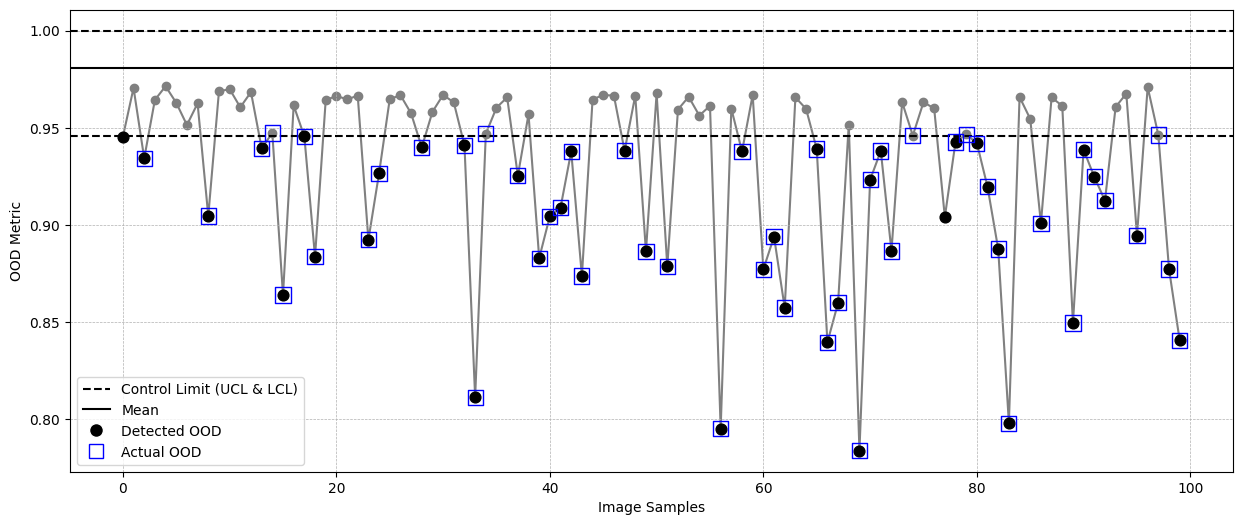

In [ ]:
import matplotlib.pyplot as plt

# Assuming the following are defined:
# combined_samples - contains the mixed in-distribution and out-of-distribution points
# ood_predictions - flags for points detected as out-of-distribution based on control limits
# labels - actual labels indicating whether a point is in-distribution (0) or out-of-distribution (1)
# cosine_3UCL_train_upper, cosine_3LCL_train_lower - control limits
# cosine_mean_train - mean cosine similarity for the training set

# Plot the SPC chart
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(combined_samples, marker='o', linestyle='-', color='grey', zorder=1)

# Plot control limits and mean
ax.axhline(np.clip(cosine_3UCL_train_upper, a_min=0.0, a_max=1.0), color='k', linestyle='--', label='Control Limit (UCL & LCL)')
ax.axhline(np.clip(cosine_3LCL_train_lower, a_min=0.0, a_max=1.0), color='k', linestyle='--')
ax.axhline(cosine_mean_train, color='k', linestyle='-', label='Mean')

# Highlight points detected as out-of-distribution with black stars
for i, val in enumerate(combined_samples):
    if ood_predictions[i] == 1:
        ax.scatter(i, val, color='black', marker='o', s=60, zorder=2)

# Circle actual out-of-distribution points with blue circles
for i, val in enumerate(combined_samples):
    if labels[i] == 1:
        ax.scatter(i, val, marker='s', facecolors='none', edgecolors='blue', s=120, zorder=3)

# Set chart properties
ax.set_facecolor('white')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Update the legend
legend_elements = [plt.Line2D([0], [0], color='k', linestyle='--', label='Control Limit (UCL & LCL)'),
                   plt.Line2D([0], [0], color='k', linestyle='-', label='Mean'),
                   plt.Line2D([0], [0], marker='o', color='w', label='Detected OOD', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='s', color='w', label='Actual OOD', markerfacecolor='none', markeredgecolor='blue', markersize=10)]
ax.legend(handles=legend_elements)

# Set chart properties (adding the axis labels here)
ax.set_xlabel('Image Samples')  # X-axis label
ax.set_ylabel('OOD Metric')    # Y-axis label
ax.set_facecolor('white')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
# Show the plot
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import resample

# Combine the cosine similarity scores and their corresponding labels
combined_scores = np.concatenate([cosine_in_dist_similarities, cosine_out_dist_similarities])
# Label: 1 for out-of-distribution, 0 for in-distribution
combined_labels = np.concatenate([np.zeros(len(cosine_in_dist_similarities)), np.ones(len(cosine_out_dist_similarities))])

# Apply the rule to flag points
ood_predictions = np.array([1 if val < cosine_3LCL_train_lower else 0 for val in combined_scores])

# Function to compute metrics
def compute_metrics(y_true, y_pred):
    sensitivity = recall_score(y_true, y_pred)  # Same as recall
    specificity = recall_score(y_true, y_pred, pos_label=0)
    accuracy = accuracy_score(y_true, y_pred)
    return sensitivity, specificity, accuracy

# Compute initial metrics
initial_sensitivity, initial_specificity, initial_accuracy = compute_metrics(combined_labels, ood_predictions)

# Bootstrapping for confidence intervals
n_iterations = 1000
n_size = int(len(combined_labels) * 0.5)  # 50% sample size
bootstrapped_metrics = []

for _ in range(n_iterations):
    # Prepare bootstrap sample
    indices = resample(np.arange(len(combined_labels)), n_samples=n_size)
    boot_labels = combined_labels[indices]
    boot_predictions = ood_predictions[indices]

    # Compute metrics
    metrics = compute_metrics(boot_labels, boot_predictions)
    bootstrapped_metrics.append(metrics)

# Convert to numpy array for easy percentile computation
bootstrapped_metrics = np.array(bootstrapped_metrics)

# Compute 95% confidence intervals
lower_p = 2.5
upper_p = 97.5
sensitivity_conf = np.percentile(bootstrapped_metrics[:, 0], [lower_p, upper_p])
specificity_conf = np.percentile(bootstrapped_metrics[:, 1], [lower_p, upper_p])
accuracy_conf = np.percentile(bootstrapped_metrics[:, 2], [lower_p, upper_p])

print("Unsupervised features (initial_sensitivity)", initial_sensitivity)
print("Unsupervised features (sensitivity_conf)", sensitivity_conf)

print("Unsupervised features (initial_specificity)", initial_specificity)
print("Unsupervised features (specificity_conf)", specificity_conf)

print("Unsupervised features (initial_accuracy)", initial_accuracy)
print("Unsupervised features (accuracy_conf)", accuracy_conf)

#initial_sensitivity, initial_specificity, initial_accuracy, sensitivity_conf, specificity_conf, accuracy_conf


NameError: ignored

In [ ]:
import numpy as np
from scipy.spatial import distance
from numpy.linalg import pinv

def compute_similarity(tr_features, tt_features, similarity_type='cosine'):
    """
    Compute similarities between training and testing features based on the specified type.

    Parameters:
    - tr_features (array): Training feature vectors.
    - tt_features (array): Testing feature vectors.
    - similarity_type (str): Type of similarity to compute ('cosine' or 'mahalanobis').

    Returns:
    - dict: Contains computed similarities and basic statistics.
    """

    def compute_cosine_similarity(tr_features_, tt_features_):
        centroid = np.mean(tr_features_, axis=0)
        return [1 - distance.cosine(feature, centroid) for feature in tt_features_]

    def compute_mahalanobis_similarity(tr_features_, tt_features_):
        covariance_matrix = np.cov(tr_features_, rowvar=False)
        covariance_matrix_inv = pinv(covariance_matrix)
        centroid = np.mean(tr_features_, axis=0)
        return [distance.mahalanobis(feature, centroid, covariance_matrix_inv) for feature in tt_features_]

    # Compute similarities
    if similarity_type == 'cosine':
        similarities = compute_cosine_similarity(tr_features, tt_features)
    elif similarity_type == 'mahalanobis':
        similarities = compute_mahalanobis_similarity(tr_features, tt_features)
    else:
        raise ValueError("Invalid similarity type. Choose 'cosine' or 'mahalanobis'.")

    # Compute statistics
    mean_similarity = np.mean(similarities)
    std_similarity = np.std(similarities)
    median_similarity = np.median(similarities)
    mad_similarity = np.median(np.abs(similarities - median_similarity))
    percentile_95 = np.percentile(similarities, 95)
    percentile_99 = np.percentile(similarities, 99)
    range_similarity = np.ptp(similarities)
    iqr_similarity = np.percentile(similarities, 75) - np.percentile(similarities, 25)

    return {
        'similarities': similarities,
        'mean': mean_similarity,
        'std': std_similarity,
        'median': median_similarity,
        'mad': mad_similarity,
        'percentile_95': percentile_95,
        'percentile_99': percentile_99,
        'range': range_similarity,
        'iqr': iqr_similarity
    }

# Example usage:
# Assuming train_features, test_in_dist_features, and test_out_dist_features are defined
#cosine_train_similarities = compute_similarity(train_features, train_features, "cosine")
mahalanobis_train_similarities = compute_similarity(train_features, train_features, "mahalanobis")
mahalanobis_train_similarities_actaul = mahalanobis_train_similarities['similarities']
print(len(mahalanobis_train_similarities_actaul))


# Print cosine statistics
#cosine_mean_train = cosine_train_similarities["mean"]
#cosine_std_train = cosine_train_similarities["std"]
#print("Cosine - MEAN train: {} | STD train: {}".format(cosine_mean_train, cosine_std_train))

# Print Mahalanobis statistics
mahalanobis_mean_train = mahalanobis_train_similarities["mean"]
mahalanobis_std_train = mahalanobis_train_similarities["std"]
# Calculate the Upper Control Limit (UCL) and Lower Control Limit (LCL)
mahalanobis_UCL_train = mahalanobis_mean_train + 3 * mahalanobis_std_train
mahalanobis_LCL_train = mahalanobis_mean_train - 3 * mahalanobis_std_train

print("Mahalanobis Train Mean: ", mahalanobis_mean_train)
print("Mahalanobis Train Std Dev: ", mahalanobis_std_train)
print("Mahalanobis Upper Control Limit (UCL): ", mahalanobis_UCL_train)
print("Mahalanobis Lower Control Limit (LCL): ", mahalanobis_LCL_train)


# Compute statistics for in-control or in-distribution test features
# Replace "cosine" with "mahalanobis" to compute Mahalanobis distances
#cosine_in_dist_similarities = compute_similarity(train_features, in_dist_features, "cosine")
#cosine_out_dist_similarities = compute_similarity(train_features, out_dist_features, "cosine")
#print("Cosine - MEAN in-dist: {} | MEAN out-dist: {}".format(cosine_in_dist_similarities["mean"], cosine_out_dist_similarities["mean"]))


scaled_in_dist_features = in_dist_features
scaled_out_dist_features = out_dist_features

mahalanobis_in_dist_similarities = compute_similarity(train_features, scaled_in_dist_features, "mahalanobis")
mahalanobis_in_dist_similarities_actual = mahalanobis_in_dist_similarities['similarities']
mahalanobis_out_dist_similarities = compute_similarity(train_features, scaled_out_dist_features, "mahalanobis")
mahalanobis_out_dist_similarities_actual = mahalanobis_out_dist_similarities['similarities']

print("Mahalanobis - MEAN in-dist: {} | MEAN out-dist: {}".format(mahalanobis_in_dist_similarities["mean"], mahalanobis_out_dist_similarities["mean"]))


5804
Mahalanobis Train Mean:  9.62137112101413
Mahalanobis Train Std Dev:  2.722496737635229
Mahalanobis Upper Control Limit (UCL):  17.78886133391982
Mahalanobis Lower Control Limit (LCL):  1.4538809081084434
Mahalanobis - MEAN in-dist: 8734.232014558746 | MEAN out-dist: 9093.634071967494


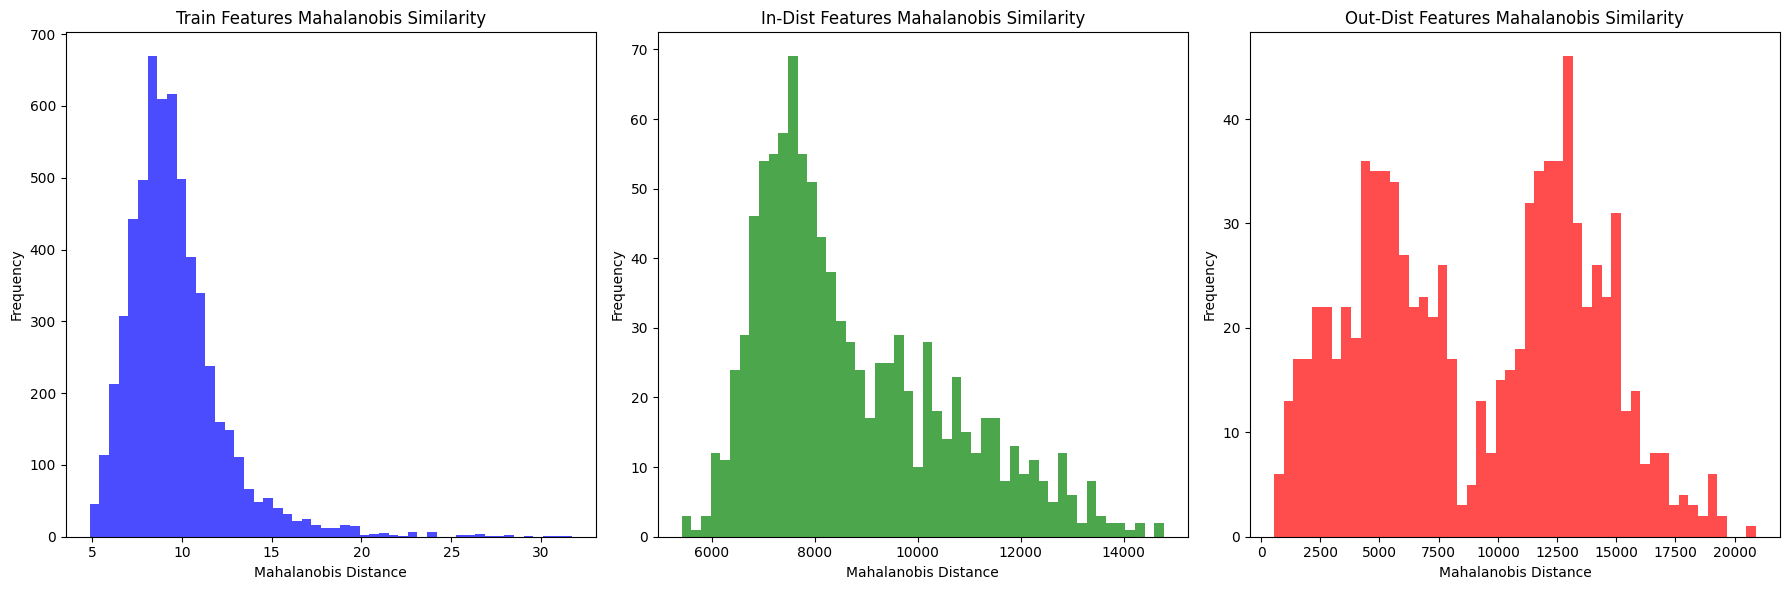

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create histograms
plt.figure(figsize=(18, 6))

# Training Features Histogram
plt.subplot(1, 3, 1)
plt.hist(mahalanobis_train_similarities_actaul, bins=50, color='blue', alpha=0.7)
plt.title('Train Features Mahalanobis Similarity')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')

# In-Dist Features Histogram
plt.subplot(1, 3, 2)
plt.hist(mahalanobis_in_dist_similarities_actual, bins=50, color='green', alpha=0.7)
plt.title('In-Dist Features Mahalanobis Similarity')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')

# Out-Dist Features Histogram
plt.subplot(1, 3, 3)
plt.hist(mahalanobis_out_dist_similarities_actual, bins=50, color='red', alpha=0.7)
plt.title('Out-Dist Features Mahalanobis Similarity')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# Randomly pick 50 points from in-distribution and out-of-distribution Mahalanobis distances
in_dist_samples_maha = np.random.choice(mahalanobis_in_dist_similarities_actual, 50, replace=False)
out_dist_samples_maha = np.random.choice(mahalanobis_out_dist_similarities_actual, 50, replace=False)

# Combine and shuffle these 100 points
combined_samples_maha = np.concatenate((in_dist_samples_maha, out_dist_samples_maha))
# Also, create a label array to track InD (0) and OOD (1) points
labels = np.array([0]*50 + [1]*50)
# Shuffle both arrays in unison
shuffled_indices_maha = np.random.permutation(np.arange(100))
combined_samples_maha = combined_samples_maha[shuffled_indices_maha]
labels = labels[shuffled_indices_maha]

print(combined_samples_maha)

# Assuming mahalanobis_LCL_train is already defined
# Identify points as in or out of distribution based on control limits
ood_predictions = [1 if val < mahalanobis_LCL_train else 0 for val in combined_samples_maha]


[13307.36979117 10457.15889271  9450.83932157 10838.44064441
  7888.26506502 10314.38577283 10195.83571569  7029.35691611
 14134.09571563  6683.96755309  7764.0648906  11977.81647195
  1958.13052995 10763.30300824  8164.68614835 11709.39707024
 12260.36601254  7410.00221818 10816.99531402 12586.06513547
  7177.51343129 12826.97682635 10939.0197924   6555.26928885
 10382.90576274  7650.03935158  7779.98952745 11694.44864636
  7252.33967784 10348.81611142  7014.0111544   4081.60217836
 12627.91229086 13014.8339531   7439.86780916  8087.86240612
  7633.30401291  8626.15272934  1659.44389703 16011.61483116
 10727.1740041   8133.33024735 12487.9009755   7809.90102442
  5950.41307065 11507.85415079 11449.41820454 13898.11654934
  7684.82272052  7716.70424587  3585.5219091   9111.34606226
  9058.53695422  3253.49226671 12785.23891681 10150.59437867
  5633.71126661  7420.42276936  9558.53951345 10057.62436412
  7139.38510656 11634.35467114 15724.05242189  7056.68601679
 13091.96410575  6675.79

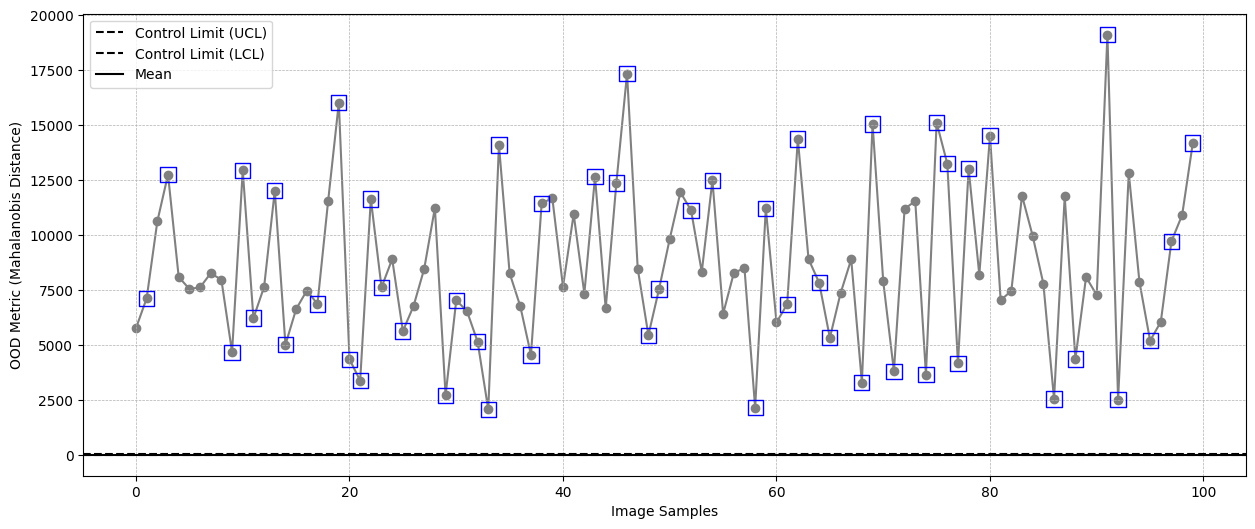

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Plot the SPC chart
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(combined_samples_maha, marker='o', linestyle='-', color='grey', zorder=1)

# Plot control limits and mean
ax.axhline(mahalanobis_UCL_train, color='k', linestyle='--', label='Control Limit (UCL)')
ax.axhline(mahalanobis_LCL_train, color='k', linestyle='--', label='Control Limit (LCL)')
ax.axhline(mahalanobis_mean_train, color='k', linestyle='-', label='Mean')

# Highlight points detected as out-of-distribution with black stars
for i, val in enumerate(combined_samples_maha):
    if ood_predictions[i] == 1:
        ax.scatter(i, val, color='black', marker='o', s=60, zorder=2)

# Circle actual out-of-distribution points with blue circles
for i, val in enumerate(combined_samples_maha):
    if labels[i] == 1:
        ax.scatter(i, val, marker='s', facecolors='none', edgecolors='blue', s=120, zorder=3)

# Set chart properties
ax.set_xlabel('Image Samples')  # X-axis label
ax.set_ylabel('OOD Metric (Mahalanobis Distance)')  # Y-axis label
ax.set_facecolor('white')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

# Show the plot
plt.show()



In [ ]:
# Function to compute metrics
def compute_metrics(y_true, y_pred):
    sensitivity = recall_score(y_true, y_pred)  # Same as recall
    specificity = recall_score(y_true, y_pred, pos_label=0)
    accuracy = accuracy_score(y_true, y_pred)
    return sensitivity, specificity, accuracy

# Bootstrapping for confidence intervals
n_iterations = 1000
bootstrapped_metrics = []
from sklearn.metrics import accuracy_score, recall_score
from sklearn.utils import resample

# Assuming the Mahalanobis distances and labels are already calculated
# ...

# Define the number of bootstrap iterations and the sample size for each iteration
n_iterations = 1000  # Number of bootstrap samples to create
n_size = int(len(combined_mahalanobis_labels) * 0.5)  # 50% sample size

# Perform bootstrapping
bootstrapped_metrics_maha = []
for _ in range(n_iterations):
    indices = resample(np.arange(len(combined_mahalanobis_labels)), n_samples=n_size)
    boot_labels_maha = combined_mahalanobis_labels[indices]
    boot_predictions_maha = ood_predictions[indices]
    metrics_maha = compute_metrics(boot_labels_maha, boot_predictions_maha)
    bootstrapped_metrics_maha.append(metrics_maha)

# Convert to numpy array and calculate confidence intervals
bootstrapped_metrics_maha = np.array(bootstrapped_metrics_maha)
lower_p = 2.5
upper_p = 97.5
sensitivity_conf_maha = np.percentile(bootstrapped_metrics_maha[:, 0], [lower_p, upper_p])
specificity_conf_maha = np.percentile(bootstrapped_metrics_maha[:, 1], [lower_p, upper_p])
accuracy_conf_maha = np.percentile(bootstrapped_metrics_maha[:, 2], [lower_p, upper_p])

print("Mahalanobis features (initial_sensitivity)", initial_sensitivity_maha)
print("Mahalanobis features (sensitivity_conf)", sensitivity_conf_maha)
print("Mahalanobis features (initial_specificity)", initial_specificity_maha)
print("Mahalanobis features (specificity_conf)", specificity_conf_maha)
print("Mahalanobis features (initial_accuracy)", initial_accuracy_maha)
print("Mahalanobis features (accuracy_conf)", accuracy_conf_maha)



TypeError: ignored